# Transmittance Calculation for Multilayer Structure

This notebook calculates the transmittance of a normal-incident plane wave through a 10-layer structure with alternating materials (ABABABABAB) using the **Transfer Matrix Method (TMM)**.

## Theoretical Background

The Transfer Matrix Method is a powerful technique for analyzing wave propagation through layered media. For electromagnetic waves at normal incidence:

1. Each layer is characterized by:
   - Thickness ($d$)
   - Refractive index ($n=\sqrt{\epsilon}$ for non-magnetic materials)
   - Permittivity ($\epsilon$)

2. The method uses 2×2 matrices to:
   - Describe wave propagation within each layer (Propagation Matrix, $P$)
   - Describe boundary conditions at interfaces (Interface Matrix, $T$)
     
The Propagation Matrix for layer $j$ is given by:
$$
P_j = \begin{pmatrix}
e^{i \delta_j} & 0 \\
0 & e^{-i \delta_j}
\end{pmatrix}
$$
 where $\delta_j = \frac{\omega n_j d_j}{c}$ is the optical phase, $\omega$ is the angular frequency, $n_j$ is the refractive index, $d_j$ is the thickness, and $c$ is the speed of light.

The Interface Matrix between layers $j-1$ and $j$ is given by:
$$
T_{j-1,j} = \frac{1}{2 n_{j-1}} \begin{pmatrix}
n_j + n_{j-1} & n_j - n_{j-1} \\
n_j - n_{j-1} & n_j + n_{j-1}
\end{pmatrix}
$$
where $n_{j-1}$ is the refractive index of the previous layer (incident), and $n_j$ is the refractive index of the current layer (transmitted).

4. The total transfer matrix is the product of all individual matrices:
   $$ M_{total} = T_N\cdots P_2T_2P_1T_1 $$

5. Transmittance is calculated from the total matrix elements:
   $$ T = \left| \frac{1}{M_{11}} \right|^2 \frac{n_{substrate}}{n_{incident}} $$

## Structure

- 10 layers alternating between Material A ($\epsilon_1$) and Material B ($\epsilon_2$)
- Pattern: ABABABABAB
- Incident medium and substrate are air ($n = 1$)

## Implementation

The following code implements this calculation in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_transmittance(wavelength, thicknesses, epsilon_1, epsilon_2):
    """
    Calculate transmittance through a 10-layer ABABABABAB structure.
    
    Parameters:
    wavelength : float
        Wavelength of incident light (in meters)
    thicknesses : list or array
        Array of 10 layer thicknesses [d1, d2, ..., d10] (in meters)
    epsilon_1 : float
        Permittivity of material A
    epsilon_2 : float
        Permittivity of material B
    
    Returns:
    float : Transmittance (0 to 1)
    """
    
    # Check input validity
    if len(thicknesses) != 10:
        raise ValueError("Exactly 10 layer thicknesses must be provided")
    
    # Constants
    c = 2.99792458e8  # speed of light in m/s
    omega = 2 * np.pi * c / wavelength  # angular frequency
    
    # Refractive indices
    n1 = np.sqrt(epsilon_1)
    n2 = np.sqrt(epsilon_2)
    n0 = 1.0  # air (incident)
    n_sub = 1.0  # air (substrate)
    
    # Layer properties (ABABABABAB)
    ns = [n1, n2] * 5
    
    # Initialize total transfer matrix
    M_total = np.eye(2, dtype=complex)
    
    # Build total transfer matrix
    for i in range(10):
        n_current = ns[i]
        d = thicknesses[i]
        
        # Phase thickness
        delta = omega * n_current * d / c
        
        # Interface matrix
        if i == 0:
            n_prev = n0
        else:
            n_prev = ns[i-1]
            
        T_interface = np.array([
            [1/(2*n_prev)*(n_current + n_prev), 1/(2*n_prev)*(n_current - n_prev)],
            [1/(2*n_prev)*(n_current - n_prev), 1/(2*n_prev)*(n_current + n_prev)]
        ])
        
        # Propagation matrix
        P = np.array([
            [np.exp(1j * delta), 0],
            [0, np.exp(-1j * delta)]
        ])
        
        # Update total matrix   P2 T2 P1 T1  
        M_total = M_total  @ P @ T_interface
    
    # Final interface to substrate
    nf = ns[-1] # final layer n 
    T_final = np.array([
        [1/(2 * nf)*(n_sub + nf), 1/(2*nf)*(n_sub - nf)],
        [1/(2 * nf)*(n_sub - nf), 1/(2*nf)*(n_sub + nf)]
    ])
    
    M_total = T_final @ M_total 
    
    # Transmission coefficient
    t = 1 / M_total[0,0] # python begins with 0
    
    # Transmittance T = np.abs(t)**2 * n_sub / n0
    T = np.abs(t)**2 * n_sub / n0
    
    return T.real

## Example Calculation

Let's calculate the transmittance for a specific case:
- Wavelength: 500 nm
- Layer thickness: 120 nm each
- Material A: $\epsilon_1$
- Material B: $\epsilon_2$

In [2]:
# Parameters
lambda0 = 500e-9  # 500 nm
d = [120e-9] * 10  # 50 nm each layer
# d = [600e-9, 0, 0, 0, 0, 0, 0, 0, 0, 0] # single layer for test
eps1 = 11.7# 
eps2 = 3.9   # 
# Calculate
T = calculate_transmittance(lambda0, d, eps1, eps2)
print(f'Transmittance: {T:.4f}')

Transmittance: 0.7141


## Wavelength Dependence

Let's plot the transmittance as a function of wavelength to see the spectral response.

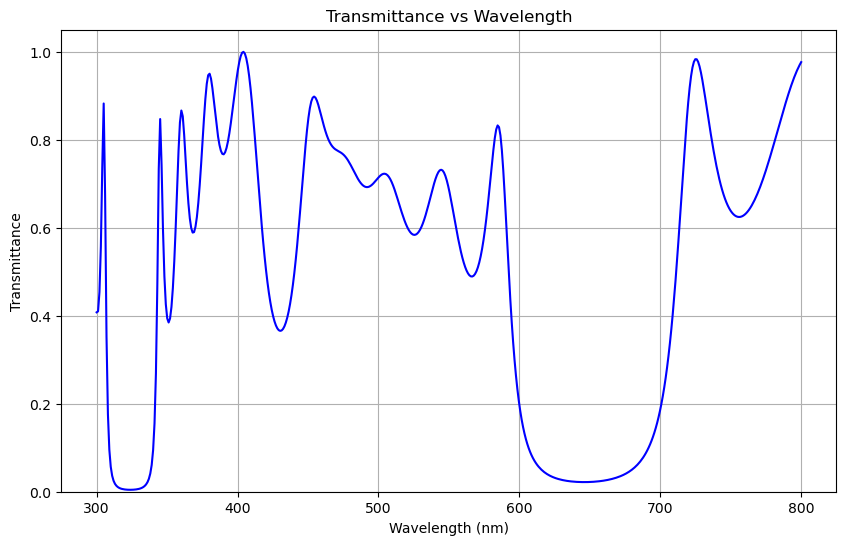

In [3]:
# Wavelength sweep
wavelengths = np.linspace(300e-9, 800e-9, 500)  # 300-800 nm
transmittances = [calculate_transmittance(wl, d, eps1, eps2) for wl in wavelengths]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths*1e9, transmittances, 'b-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()

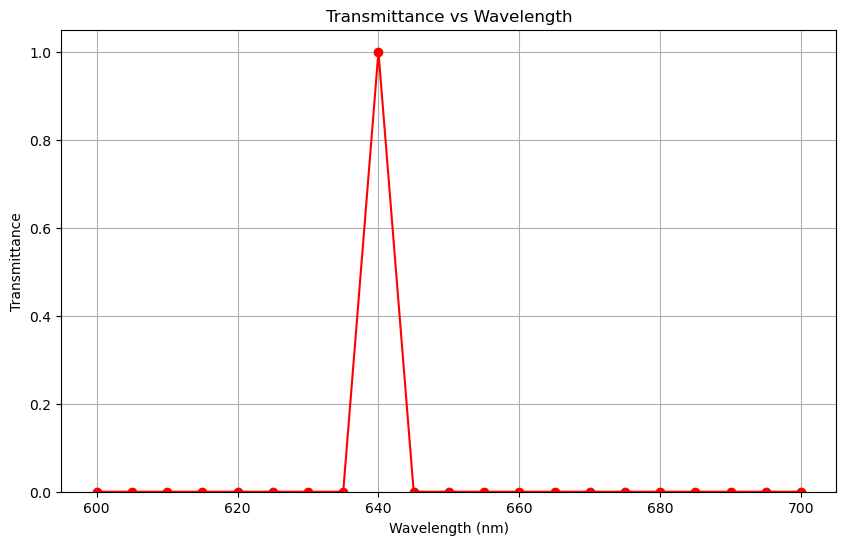

In [4]:
target_wl = np.linspace(600e-9,700e-9,21)
target_trans = np.zeros(21)
target_trans[8] = 1 
#target_trans[16] = 1

# Plot
plt.figure(figsize=(10, 6))
plt.plot(target_wl * 1e9, target_trans, 'r-o')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()


In [5]:
#  figure of merit
def fom(thicknesses):
    lw = len(target_wl)
    trans = np.zeros(lw)
    for i in range(lw):
        trans[i] = calculate_transmittance(target_wl[i], thicknesses, eps1, eps2)
    output = np.sum((trans - target_trans)**2)/lw
    return output

In [6]:
fom(d)

0.051966391349498264

In [7]:
from pyswarm import pso #pip install pyswarm

# Define the objective function (example: sum of squares)
# Replace this with your actual function


# Define bounds for the 10 parameters
lb = np.zeros(10)          # Lower bound: 0 for all d_i
ub = np.ones(10) * 300e-9  # Upper bound: 300e-9 for all d_i

# Run PSO optimization
best_position, best_value = pso(
    fom,    # Function to minimize
    lb,                    # Lower bounds
    ub,                    # Upper bounds
    swarmsize=100,          # Number of particles
    maxiter=1000,           # Maximum iterations
    debug=False,             # Print progress
    minstep = 0.5e-9
)

# Print results
print("\nOptimization Results:")
print("Best parameters (d_i):")
for i, d in enumerate(best_position):
    print(f"d_{i+1} = {d:.2e}")
print(f"Minimum value of f: {best_value:.2e}")

ModuleNotFoundError: No module named 'pyswarm'

In [8]:
# Wavelength sweep
wavelengths = np.linspace(600e-9, 700e-9, 21)  # 300-800 nm
transmittances = [calculate_transmittance(wl, best_position, eps1, eps2) for wl in wavelengths]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths*1e9, transmittances, 'b-')
plt.plot(target_wl * 1e9, target_trans, 'r--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()

NameError: name 'best_position' is not defined

In [9]:
from simanneal import Annealer #pip install simanneal 

# Define the objective function (example: sum of squares)


# Define the Simulated Annealing problem
class ParameterOptimization(Annealer):
    def __init__(self, initial_state):
        super(ParameterOptimization, self).__init__(initial_state)
        self.bounds = (0, 300e-9)  # Bounds for d_i

    # Define how to perturb the state (move to a neighbor)
    def move(self):
        # Randomly perturb one parameter
        step_size = 50e-9
        step = step_size * np.random.uniform(-1,1,10) / np.sqrt(10)   # Small random step
        self.state += step
        # Enforce bounds
        self.state = np.clip(self.state, self.bounds[0], self.bounds[1])

    # Define the energy (objective function to minimize)
    def energy(self):
        return fom(self.state)

# Run the optimization
def SA_sim():
    # Initial state: random values between 0 and 300e-9 for 10 parameters
    initial_state = np.random.uniform(0, 300e-9, 10)

    # Set up the annealer
    problem = ParameterOptimization(initial_state)
    problem.Tmax = 25000.0  # Initial temperature
    problem.Tmin = 1      # Final temperature
    problem.steps = 10000   # Number of iterations

    # Run simulated annealing
    best_state, best_energy = problem.anneal()

    # Print results
    print("\nOptimization Results:")
    print("Best parameters (d_i):")
    for i, d in enumerate(best_state):
        print(f"d_{i+1} = {d:.2e}")
    print(f"Minimum value of f: {best_energy:.2e}")

    return best_state, best_energy

best_state, best_energy = SA_sim()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     1.00000          0.15    99.00%    50.00%     0:00:19     0:00:00


Optimization Results:
Best parameters (d_i):
d_1 = 2.36e-07
d_2 = 5.33e-08
d_3 = 2.44e-07
d_4 = 1.14e-07
d_5 = 2.77e-07
d_6 = 2.09e-07
d_7 = 1.46e-07
d_8 = 2.27e-07
d_9 = 2.46e-07
d_10 = 2.34e-07
Minimum value of f: 2.10e-02


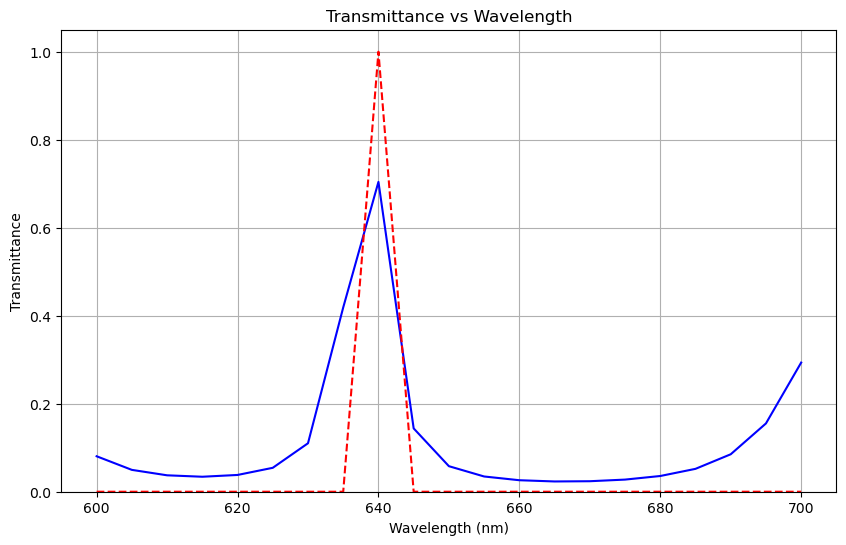

In [10]:
# Wavelength sweep
wavelengths = np.linspace(600e-9, 700e-9, 21)  # 300-800 nm
transmittances = [calculate_transmittance(wl, best_state, eps1, eps2) for wl in wavelengths]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths*1e9, transmittances, 'b-')
plt.plot(target_wl * 1e9, target_trans, 'r--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()

In [11]:
from scipy.optimize import minimize


# Define bounds for the 10 parameters
bounds = [(0, 300e-9) for _ in range(10)]  # Each d_i between 0 and 300e-9

# Initial guess: random values within bounds
initial_guess = np.random.uniform(0, 300e-9, 10)

# Run optimization

#  Set Optimization Options
# We increase 'maxiter' and set 'disp' to True to see the optimization output.
# 'adaptive=True' can sometimes help Nelder-Mead handle higher dimensions better.
options = {
    'disp': True,          # Print convergence messages
    'xatol': 1e-9,         # Absolute error in xopt between iterations that is acceptable for convergence.
    'fatol': 1e-8,         # Absolute error in func(xopt) between iterations that is acceptable for convergence.
    'adaptive': True,      # Use adaptive parameters proposed by Gao and Han (2012) - may improve performance
    'maxfev': 10000 
}


result = minimize(
    fom,    # Function to minimize
    initial_guess,         # Starting point
    method='Nelder-Mead',       # Use Powell's method
    bounds=bounds,         # Parameter constraints
    options= options   
)
# Extract results
best_params = result.x
best_value = result.fun

# Print results
print("\nOptimization Results:")
print("Best parameters (d_i):")
for i, d in enumerate(best_params):
    print(f"d_{i+1} = {d:.2e}")
print(f"Minimum value of f: {best_value:.2e}")

Optimization terminated successfully.
         Current function value: 0.003534
         Iterations: 1394
         Function evaluations: 2057

Optimization Results:
Best parameters (d_i):
d_1 = 1.41e-07
d_2 = 8.11e-08
d_3 = 1.41e-07
d_4 = 8.12e-08
d_5 = 2.80e-07
d_6 = 2.44e-07
d_7 = 1.41e-07
d_8 = 2.44e-07
d_9 = 1.41e-07
d_10 = 8.11e-08
Minimum value of f: 3.53e-03


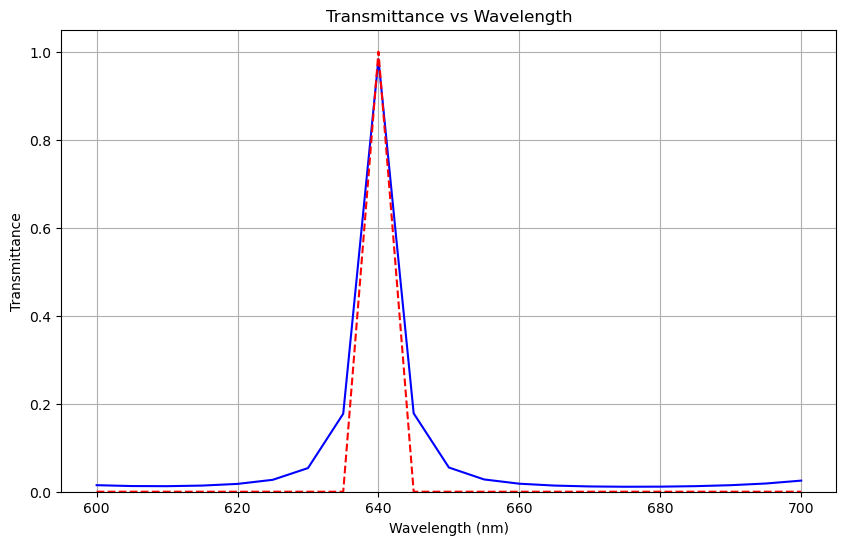

In [12]:
# Wavelength sweep
wavelengths = np.linspace(600e-9, 700e-9, 21)  # 300-800 nm
transmittances = [calculate_transmittance(wl, best_params, eps1, eps2) for wl in wavelengths]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths*1e9, transmittances, 'b-')
plt.plot(target_wl * 1e9, target_trans, 'r--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()

In [13]:
import numpy as np
import random
from deap import base, creator, tools, algorithms

# Define the objective function
def objective_function(d):
    return fom(d)  # Minimize sum of d_i^2

# Wrapper for DEAP to evaluate individuals
def evaluate(individual):
    d = np.array(individual)
    return (objective_function(d),)  # Return a tuple as required by DEAP

# Custom mutation that respects bounds
def bounded_mutation(individual, mu, sigma, indpb, min_bound, max_bound):
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] += random.gauss(mu, sigma)
            individual[i] = max(min_bound, min(max_bound, individual[i]))
    return individual,

# Custom function to enforce bounds after crossover
def enforce_bounds(min_bound, max_bound):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for child in offspring:
                for i in range(len(child)):
                    child[i] = max(min_bound, min(max_bound, child[i]))
            return offspring
        return wrapper
    return decorator

# Check if FitnessMin and Individual are already defined to avoid warnings
if not hasattr(creator, 'FitnessMin'):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize fitness
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMin)

# Set up the GA
def setup_ga():
    toolbox = base.Toolbox()
    MIN_BOUND, MAX_BOUND = 0, 300e-9
    toolbox.register("attr_float", random.uniform, MIN_BOUND, MAX_BOUND)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=10)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", enforce_bounds(MIN_BOUND, MAX_BOUND)(tools.cxBlend), alpha=0.5)
    toolbox.register("mutate", bounded_mutation, mu=0, sigma=50e-9, indpb=0.2, 
                     min_bound=MIN_BOUND, max_bound=MAX_BOUND)
    toolbox.register("select", tools.selTournament, tournsize=3)
    return toolbox, MIN_BOUND, MAX_BOUND

# Main GA function
def GA_sim():
    # Set random seed (optional: uncomment for reproducibility)
    # random.seed(42)
    # np.random.seed(42)
    random.seed()
    np.random.seed()

    # Initialize toolbox
    toolbox, MIN_BOUND, MAX_BOUND = setup_ga()

    # Create population
    population = toolbox.population(n=200)
    
    # Evaluate initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Initialize Hall of Fame and seed it with evaluated population
    hof = tools.HallOfFame(1)
    hof.update(population)

    # GA parameters
    CXPB, MUTPB = 0.7, 0.2 # Crossover and mutation probabilities
    NGEN = 1000 # Number of generations

    # Run the GA
    pop, logbook = algorithms.eaSimple(
        population,
        toolbox,
        cxpb=CXPB,
        mutpb=MUTPB,
        ngen=NGEN,
        halloffame=hof, # <--- Add this argument
        verbose=True
    )

    # Extract the best individual from final population
    best_individual = tools.selBest(pop, k=1)[0]
    best_params = np.array(best_individual)
    best_value = objective_function(best_params)
    fitness_pop = best_individual.fitness.values[0]

    # Extract the historical best from Hall of Fame
    if len(hof) == 0:
        print("Warning: Hall of Fame is empty!")
        best_params_historical = best_params
        best_value_historical = best_value
    else:
        best_historical = hof[0]
        best_params_historical = np.array(best_historical)
        best_value_historical = objective_function(best_params_historical)
        fitness_historical = best_historical.fitness.values[0]

    # Debugging fitness consistency
    print(f"\nDebugging Fitness Consistency:")
    print(f"Final Pop - Stored Fitness: {fitness_pop:.2e}, Computed: {best_value:.2e}")
    if len(hof) > 0:
        print(f"Historical - Stored Fitness: {fitness_historical:.2e}, Computed: {best_value_historical:.2e}")

    # Check if HoF is worse than final population
    if best_value_historical > best_value:
        print("Warning: Historical best is worse than final population best!")

    # Print results
    print("\nOptimization Results:")
    print("Best parameters from final population (d_i):")
    for i, d in enumerate(best_params):
        print(f"d_{i+1} = {d:.2e}")
    print(f"Minimum value of f (final population): {best_value:.2e}")

    print("\nHistorical Best Parameters (d_i):")
    for i, d in enumerate(best_params_historical):
        print(f"d_{i+1} = {d:.2e}")
    print(f"Minimum value of f (historical best): {best_value_historical:.2e}")

    return best_params, best_params_historical

if __name__ == "__main__":
    best_params, best_params_historical = GA_sim()

gen	nevals
0  	0     
1  	149   
2  	166   
3  	133   
4  	151   
5  	149   
6  	138   
7  	152   
8  	148   
9  	149   
10 	140   
11 	145   
12 	146   
13 	153   
14 	156   
15 	154   
16 	146   
17 	137   
18 	161   
19 	167   
20 	157   
21 	151   
22 	166   
23 	168   
24 	154   
25 	150   
26 	154   
27 	145   
28 	159   
29 	147   
30 	156   
31 	150   
32 	145   
33 	155   
34 	154   
35 	143   
36 	158   
37 	152   
38 	158   
39 	146   
40 	160   
41 	162   
42 	148   
43 	144   
44 	140   
45 	153   
46 	141   
47 	147   
48 	159   
49 	157   
50 	158   
51 	136   
52 	153   
53 	150   
54 	143   
55 	158   
56 	155   
57 	165   
58 	147   
59 	165   
60 	157   
61 	155   
62 	141   
63 	167   
64 	159   
65 	146   
66 	134   
67 	160   
68 	161   
69 	159   
70 	160   
71 	151   
72 	148   
73 	151   
74 	155   
75 	145   
76 	144   
77 	157   
78 	158   
79 	135   
80 	141   
81 	150   
82 	155   
83 	158   
84 	158   
85 	130   
86 	142   
87 	154   
88 	157   
89 	169   

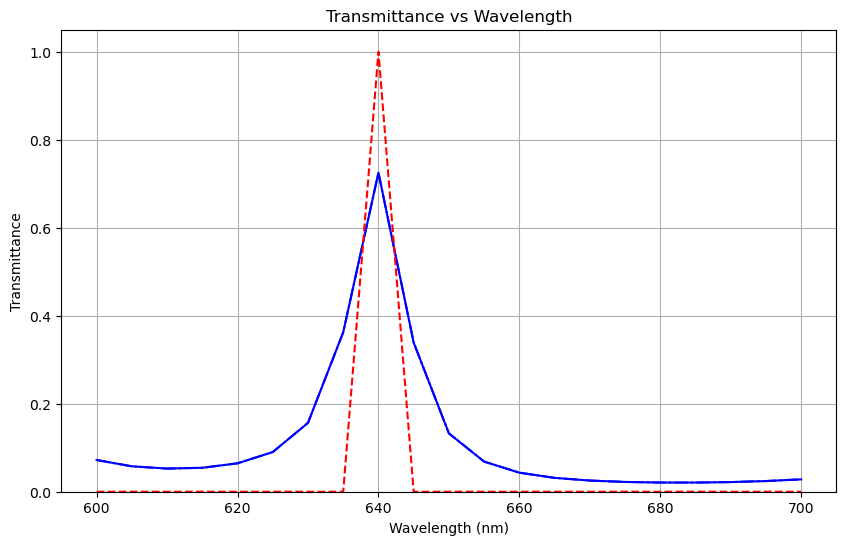

In [14]:
# Wavelength sweep
wavelengths = np.linspace(600e-9, 700e-9, 21)  # 300-800 nm
transmittances_hof = [calculate_transmittance(wl, best_params_historical, eps1, eps2) for wl in wavelengths]
transmittances = [calculate_transmittance(wl, best_params, eps1, eps2) for wl in wavelengths]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths*1e9, transmittances, 'b-')
plt.plot(wavelengths*1e9, transmittances_hof, 'b-.')
plt.plot(target_wl * 1e9, target_trans, 'r--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()

In [15]:
from scipy.optimize import differential_evolution

# Define the objective function (example: sum of squares)
# Replace this with your actual function
def objective_function(d):
    return fom(d)  # Example: minimize sum of d_i^2

# Define bounds for the 10 parameters
bounds = [(0, 300e-9) for _ in range(10)]  # Each d_i between 0 and 300e-9

# Run Differential Evolution
result = differential_evolution(
    objective_function,    # Function to minimize
    bounds,                # Parameter bounds
    strategy='best1bin',   # DE strategy (can adjust: 'best1bin', 'rand1exp', etc.)
    maxiter=500,          # Maximum iterations
    popsize=30,            # Population size multiplier (15 * 10 = 150 individuals)
    tol=1e-9,              # Convergence tolerance
    mutation=(0.5, 1),     # Mutation factor range
    recombination=0.7,     # Crossover probability
 #  seed=42,               # Random seed for reproducibility
    disp=True              # Print progress
)

# Extract results
best_params = result.x
best_value = result.fun

# Print results
print("\nOptimization Results:")
print("Best parameters (d_i):")
for i, d in enumerate(best_params):
    print(f"d_{i+1} = {d:.2e}")
print(f"Minimum value of f: {best_value:.2e}")

# Optional: return results for further use
# return best_params, best_value

differential_evolution step 1: f(x)= 0.025368
differential_evolution step 2: f(x)= 0.025368
differential_evolution step 3: f(x)= 0.0181882
differential_evolution step 4: f(x)= 0.0181882
differential_evolution step 5: f(x)= 0.0181882
differential_evolution step 6: f(x)= 0.0181882
differential_evolution step 7: f(x)= 0.0181882
differential_evolution step 8: f(x)= 0.0181882
differential_evolution step 9: f(x)= 0.0181882
differential_evolution step 10: f(x)= 0.0181882
differential_evolution step 11: f(x)= 0.0181882
differential_evolution step 12: f(x)= 0.0181882
differential_evolution step 13: f(x)= 0.0181882
differential_evolution step 14: f(x)= 0.0181882
differential_evolution step 15: f(x)= 0.0181882
differential_evolution step 16: f(x)= 0.0181882
differential_evolution step 17: f(x)= 0.0181882
differential_evolution step 18: f(x)= 0.0181882
differential_evolution step 19: f(x)= 0.0181882
differential_evolution step 20: f(x)= 0.0181882
differential_evolution step 21: f(x)= 0.0181882
dif

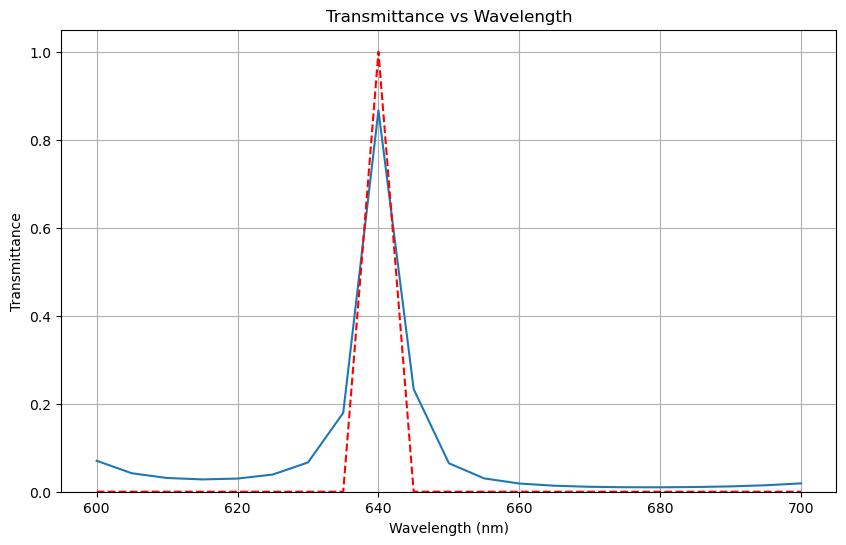

In [16]:
# Wavelength sweep
wavelengths = np.linspace(600e-9, 700e-9, 21)  # 300-800 nm
transmittances = [calculate_transmittance(wl, best_params, eps1, eps2) for wl in wavelengths]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths*1e9, transmittances, '-')
plt.plot(target_wl * 1e9, target_trans, 'r--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()

In [17]:
# Zebra Optimization Algorithm
# pip install --upgrade mealpy
import numpy as np
from mealpy.swarm_based import ZOA
from mealpy import FloatVar

# Define your objective function
def objective_function(solution):
    return fom(solution)

# Define the problem
problem = {
    "bounds": FloatVar(lb=([0]*10) , ub=([300e-9]*10) , name="delta"),
    "minmax": "min",
    "obj_func": objective_function,
    "verbose": False
}

# Initialize the ZOA model
model = ZOA.OriginalZOA(epoch=100, pop_size=500)

# Solve the optimization problem
best_agent = model.solve(problem)
best_solution = best_agent.solution
best_fitness = best_agent.target.fitness


print(f"Best Solution: {best_solution}")
print(f"Best Fitness: {best_fitness}")

2025/04/15 05:51:02 AM, INFO, mealpy.swarm_based.ZOA.OriginalZOA: Solving single objective optimization problem.
2025/04/15 05:51:04 AM, INFO, mealpy.swarm_based.ZOA.OriginalZOA: >>>Problem: P, Epoch: 1, Current best: 0.03799626074130216, Global best: 0.03799626074130216, Runtime: 1.85283 seconds
2025/04/15 05:51:06 AM, INFO, mealpy.swarm_based.ZOA.OriginalZOA: >>>Problem: P, Epoch: 2, Current best: 0.03799626074130216, Global best: 0.03799626074130216, Runtime: 1.91705 seconds
2025/04/15 05:51:08 AM, INFO, mealpy.swarm_based.ZOA.OriginalZOA: >>>Problem: P, Epoch: 3, Current best: 0.03799626074130216, Global best: 0.03799626074130216, Runtime: 1.84414 seconds
2025/04/15 05:51:10 AM, INFO, mealpy.swarm_based.ZOA.OriginalZOA: >>>Problem: P, Epoch: 4, Current best: 0.03799626074130216, Global best: 0.03799626074130216, Runtime: 1.84412 seconds
2025/04/15 05:51:12 AM, INFO, mealpy.swarm_based.ZOA.OriginalZOA: >>>Problem: P, Epoch: 5, Current best: 0.03799626074130216, Global best: 0.037996

Best Solution: [1.43760136e-07 2.25819010e-07 1.36553346e-07 1.03409393e-07
 1.23477516e-07 1.86394883e-07 2.21696406e-07 7.74228165e-08
 4.85482573e-08 1.01222654e-07]
Best Fitness: 0.016456103157561092


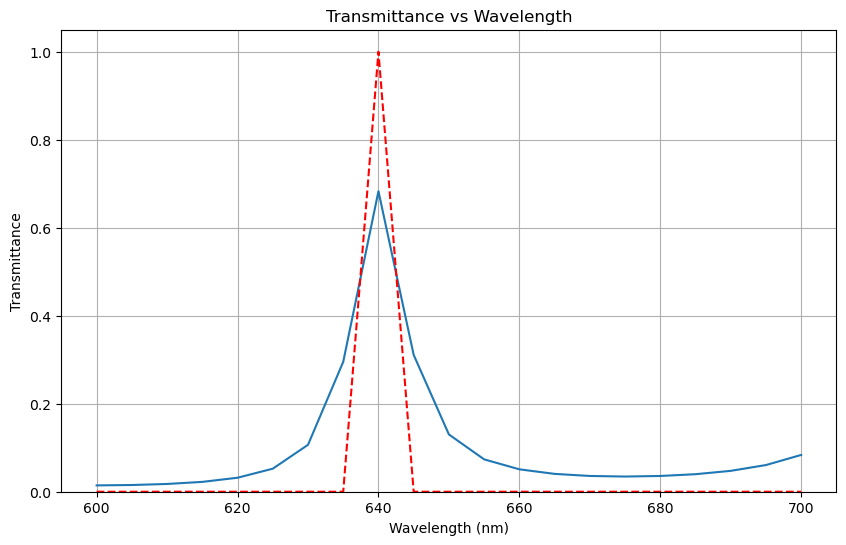

In [18]:
# Wavelength sweep
wavelengths = np.linspace(600e-9, 700e-9, 21)  # 300-800 nm
transmittances = [calculate_transmittance(wl, best_solution, eps1, eps2) for wl in wavelengths]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths*1e9, transmittances, '-')
plt.plot(target_wl * 1e9, target_trans, 'r--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.ylim([0,1.05])
plt.title('Transmittance vs Wavelength')
plt.grid(True)
plt.show()

## Use Python script for a long computation
`ipynb` or Jupyter Notebook is a good environment for initializing code and playing with it.
But, it is not ideal if you want to run a long simulation and leave for lunch. In this case, 
you run the code in the terminal with `nohup`

```
nohup python 04_OTID_trans_TMM_zoa.py > zoa.out &
```

I wrote a Python file `04_OTID_trans_TMM_zoa.py` to wrap the transmission calculation as a function by writing
``` python
def calculate_transmittance(wavelength, thicknesses, epsilon_1, epsilon_2):
```
In `04_OTID_trans_TMM_zoa.py`, I also wrote the optimization

``` python
# Zebra Optimization Algorithm
# pip install --upgrade mealpy
from mealpy.swarm_based import ZOA
from mealpy import FloatVar

# Define your objective function
def objective_function(solution):
    return fom(solution)

# Define the problem
problem = {
    "bounds": FloatVar(lb=([0]*10) , ub=([300e-9]*10) , name="delta"),
    "minmax": "min",
    "obj_func": objective_function,
    "verbose": False
}

# Initialize the ZOA model
model = ZOA.OriginalZOA(epoch=100, pop_size=100)

# Solve the optimization problem
best_agent = model.solve(problem)
best_solution = best_agent.solution
best_fitness = best_agent.target.fitness


print(f"Best Solution: {best_solution}")
print(f"Best Fitness: {best_fitness}")

```

- First, run the code with the command
```
nohup python 04_OTID_trans_TMM_zoa.py > zoa.out &
```
- See the result files.
- Write your own file by replacing the optimization method.

